In [1]:
import numpy as np
from model_vanilla_zoom import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/rot2d_NoAug_argminW_lr0.0002_nomaxdivision_20/checkpoint"
sample_dir = "./out/rot2d_NoAug_argminW_lr0.0002_nomaxdivision_20/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

zoom aug is disabled
loading mnist without augmenting ...
 [*] Reading checkpoints... ./out/rot2d_NoAug_argminW_lr0.0002_nomaxdivision_20/checkpoint
INFO:tensorflow:Restoring parameters from ./out/rot2d_NoAug_argminW_lr0.0002_nomaxdivision_20/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


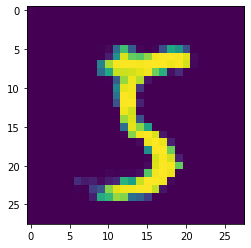

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    target_fn = np.copy(outputs_zs)
    mask_fn = np.ones(outputs_zs.shape)
#     print('rotate with alphas:', alpha)
    mask_out = np.zeros(outputs_zs.shape)

    for i in range(outputs_zs.shape[0]):
        if alpha!=0:
            M = cv2.getRotationMatrix2D((img_size//2, img_size//2), alpha, 1)
            target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
        else:
            mask_out[i,:,:,:] = mask_fn[i,:,:,:]

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)

    if show_img:
        print('Target image:')
        imshow(imgrid(np.uint8(target_fn*255), cols=4))

    if show_mask:
        print('Target mask:')
        imshow(imgrid(np.uint8(mask_out*255), cols=4))

    return target_fn, mask_out


In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/rot2d_aug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 10)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-16 21:18:17,562 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.17744994163513184, 0, 0, 0.14903642237186432, -8
2019-09-16 21:18:17,570 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007107734680175781, 0, 10, 0.14894947409629822, 7
2019-09-16 21:18:17,580 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008479118347167969, 0, 20, 0.15258194506168365, -8
2019-09-16 21:18:17,590 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008611679077148438, 0, 30, 0.1591181606054306, 8
2019-09-16 21:18:17,600 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008983373641967773, 0, 40, 0.07943009585142136, 1
2019-09-16 21:18:17,611 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009188175201416016, 0, 50, 0.13682793080806732, -8
2019-09-16 21:18:17,621 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009401559829711914, 0, 60, 0.12663967907428741, 5
2019-09-16 21:18:17,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009018659591674805, 0, 70, 0.10857158154249191, -5
2019-09-16 21:18:17,642 [MainTh

2019-09-16 21:18:18,267 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00897073745727539, 0, 680, 0.12298104166984558, -7
2019-09-16 21:18:18,278 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009433269500732422, 0, 690, 0.12881723046302795, -9
2019-09-16 21:18:18,288 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009215593338012695, 0, 700, 0.13671478629112244, -7
2019-09-16 21:18:18,299 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009185791015625, 0, 710, 0.09384720772504807, -3
2019-09-16 21:18:18,309 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008912324905395508, 0, 720, 0.09081673622131348, -6
2019-09-16 21:18:18,319 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008867502212524414, 0, 730, 0.12623678147792816, -8
2019-09-16 21:18:18,329 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008825063705444336, 0, 740, 0.09132743626832962, 3
2019-09-16 21:18:18,339 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00902700424194336, 0, 750, 0.03930393233895302, 1
2019-09-16 21:18:18,349

2019-09-16 21:18:18,942 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00874018669128418, 0, 1350, 0.04259577766060829, -3
2019-09-16 21:18:18,952 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008703231811523438, 0, 1360, 0.08855269849300385, 6
2019-09-16 21:18:18,962 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008823633193969727, 0, 1370, 0.05818263813853264, -4
2019-09-16 21:18:18,972 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008559703826904297, 0, 1380, 0.08182023465633392, -5
2019-09-16 21:18:18,982 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00928187370300293, 0, 1390, 0.08790144324302673, -6
2019-09-16 21:18:18,993 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009298086166381836, 0, 1400, 0.06566115468740463, 3
2019-09-16 21:18:19,003 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00869607925415039, 0, 1410, 0.061135780066251755, 3
2019-09-16 21:18:19,013 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008887767791748047, 0, 1420, 0.10442867875099182, -9
2019-09-16 21

2019-09-16 21:18:19,611 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009479761123657227, 0, 2010, 0.09355974197387695, 7
2019-09-16 21:18:19,621 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008700370788574219, 0, 2020, 0.08606469631195068, 7
2019-09-16 21:18:19,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008756875991821289, 0, 2030, 0.11283108592033386, 7
2019-09-16 21:18:19,641 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009126424789428711, 0, 2040, 0.04852338507771492, 3
2019-09-16 21:18:19,652 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00913095474243164, 0, 2050, 0.033087532967329025, -3
2019-09-16 21:18:19,663 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009638309478759766, 0, 2060, 0.018535645678639412, -2
2019-09-16 21:18:19,673 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008565187454223633, 0, 2070, 0.047148797661066055, -4
2019-09-16 21:18:19,683 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008951663970947266, 0, 2080, 0.09431743621826172, 8
2019-09-16 

2019-09-16 21:18:20,288 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00917363166809082, 0, 2680, 0.00824258103966713, 1
2019-09-16 21:18:20,299 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009033441543579102, 0, 2690, 0.07914364337921143, -7
2019-09-16 21:18:20,309 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008781671524047852, 0, 2700, 0.08769165724515915, -7
2019-09-16 21:18:20,319 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009120464324951172, 0, 2710, 0.03371250256896019, -3
2019-09-16 21:18:20,329 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009157657623291016, 0, 2720, 0.025844866409897804, 2
2019-09-16 21:18:20,339 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008812189102172852, 0, 2730, 0.05007792264223099, 4
2019-09-16 21:18:20,349 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008888483047485352, 0, 2740, 0.06755556911230087, 5
2019-09-16 21:18:20,360 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008952140808105469, 0, 2750, 0.030559193342924118, 3
2019-09-16 2

2019-09-16 21:18:20,972 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008841514587402344, 0, 3340, 0.07974422723054886, 7
2019-09-16 21:18:20,982 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00886082649230957, 0, 3350, 0.05152350291609764, 4
2019-09-16 21:18:20,992 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008867979049682617, 0, 3360, 0.09481202811002731, -8
2019-09-16 21:18:21,002 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008477210998535156, 0, 3370, 0.042704638093709946, -4
2019-09-16 21:18:21,012 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008937835693359375, 0, 3380, 0.023936457931995392, -3
2019-09-16 21:18:21,020 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0073604583740234375, 0, 3390, 0.0426534041762352, 3
2019-09-16 21:18:21,028 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006560087203979492, 0, 3400, 0.01690913923084736, -2
2019-09-16 21:18:21,037 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008569955825805664, 0, 3410, 0.06888865679502487, -6
2019-09-16

Loss: [0.011197409335523843, 0.007427526078652591, 0.006037679680390284, 0.00569678352214396]
2019-09-16 21:18:21,640 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009202718734741211, 0, 4010, 0.03833092004060745, -4
2019-09-16 21:18:21,650 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008764505386352539, 0, 4020, 0.04406251758337021, -4
2019-09-16 21:18:21,660 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008652687072753906, 0, 4030, 0.09625814855098724, -9
2019-09-16 21:18:21,670 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008933305740356445, 0, 4040, 0.061426326632499695, 5
2019-09-16 21:18:21,680 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008807897567749023, 0, 4050, 0.01874268800020218, 2
2019-09-16 21:18:21,690 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008963584899902344, 0, 4060, 0.07979132980108261, -7
2019-09-16 21:18:21,701 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009557723999023438, 0, 4070, 0.10588698834180832, 9
2019-09-16 21:18:21,716 [MainThread  ] [

2019-09-16 21:18:22,331 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009249687194824219, 0, 4670, 0.08963046967983246, 9
2019-09-16 21:18:22,341 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00865936279296875, 0, 4680, 0.02917943149805069, 4
2019-09-16 21:18:22,351 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008779525756835938, 0, 4690, 0.03895597532391548, 4
2019-09-16 21:18:22,361 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009059906005859375, 0, 4700, 0.02590176649391651, 4
2019-09-16 21:18:22,370 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00887441635131836, 0, 4710, 0.012077092193067074, 2
2019-09-16 21:18:22,380 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008860111236572266, 0, 4720, 0.012362106703221798, -2
2019-09-16 21:18:22,390 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008960247039794922, 0, 4730, 0.07519447803497314, -7
2019-09-16 21:18:22,400 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008598566055297852, 0, 4740, 0.031117603182792664, -4
2019-09-16 2

2019-09-16 21:18:22,998 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009218215942382812, 0, 5330, 0.003465152345597744, 1
2019-09-16 21:18:23,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008625507354736328, 0, 5340, 0.0026219836436212063, -1
2019-09-16 21:18:23,017 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009036540985107422, 0, 5350, 0.07875194400548935, 9
2019-09-16 21:18:23,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008825063705444336, 0, 5360, 0.0032210885547101498, -1
2019-09-16 21:18:23,037 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008708953857421875, 0, 5370, 0.002627878449857235, 1
2019-09-16 21:18:23,047 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008993864059448242, 0, 5380, 0.06578714400529861, -8
2019-09-16 21:18:23,057 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008905172348022461, 0, 5390, 0.054034508764743805, 8
2019-09-16 21:18:23,069 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011673927307128906, 0, 5400, 0.010225169360637665, -2
2019

2019-09-16 21:18:23,676 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008850812911987305, 0, 6000, 0.04077614098787308, 5
Loss: [0.011197409335523843, 0.007427526078652591, 0.006037679680390284, 0.00569678352214396, 0.004661163934273646, 0.0036598629518412055]
2019-09-16 21:18:23,686 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009219884872436523, 0, 6010, 0.03716845065355301, -5
2019-09-16 21:18:23,696 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008906126022338867, 0, 6020, 0.002290063537657261, -1
2019-09-16 21:18:23,706 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008835554122924805, 0, 6030, 0.010510103777050972, -2
2019-09-16 21:18:23,716 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008995532989501953, 0, 6040, 0.008942955173552036, -2
2019-09-16 21:18:23,726 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009328126907348633, 0, 6050, 0.026387671008706093, 4
2019-09-16 21:18:23,736 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00892329216003418, 0, 6060, 0.00263816886581

2019-09-16 21:18:24,341 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009143590927124023, 0, 6650, 0.010539376176893711, 3
2019-09-16 21:18:24,351 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009050607681274414, 0, 6660, 0.007294253911823034, -2
2019-09-16 21:18:24,361 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009288311004638672, 0, 6670, 0.033955659717321396, 6
2019-09-16 21:18:24,372 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00972127914428711, 0, 6680, 0.001467579510062933, -1
2019-09-16 21:18:24,382 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008791923522949219, 0, 6690, 0.012245144695043564, -3
2019-09-16 21:18:24,392 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00903177261352539, 0, 6700, 0.012800020165741444, -3
2019-09-16 21:18:24,402 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008897542953491211, 0, 6710, 0.027866991236805916, -5
2019-09-16 21:18:24,412 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009066104888916016, 0, 6720, 0.051547661423683167, 8
2019-

2019-09-16 21:18:24,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009241104125976562, 0, 7300, 0.055641938000917435, 8
2019-09-16 21:18:25,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009285449981689453, 0, 7310, 0.045303162187337875, -9
2019-09-16 21:18:25,017 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009185075759887695, 0, 7320, 0.05772252380847931, 9
2019-09-16 21:18:25,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009157180786132812, 0, 7330, 0.005275806412100792, 2
2019-09-16 21:18:25,038 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009328603744506836, 0, 7340, 0.002007891656830907, -1
2019-09-16 21:18:25,048 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009362459182739258, 0, 7350, 0.0468975305557251, 8
2019-09-16 21:18:25,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009106874465942383, 0, 7360, 0.028397930786013603, 5
2019-09-16 21:18:25,068 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00911402702331543, 0, 7370, 0.06048625335097313, 9
2019-09-16 

2019-09-16 21:18:25,685 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009160041809082031, 0, 7970, 0.010584905743598938, 3
2019-09-16 21:18:25,695 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008894205093383789, 0, 7980, 0.0446336567401886, 8
2019-09-16 21:18:25,705 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008814334869384766, 0, 7990, 0.013369112275540829, 4
2019-09-16 21:18:25,714 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00847935676574707, 0, 8000, 0.0017155796522274613, -1
Loss: [0.011197409335523843, 0.007427526078652591, 0.006037679680390284, 0.00569678352214396, 0.004661163934273646, 0.0036598629518412055, 0.0028764121882850304, 0.0027040908484486864]
2019-09-16 21:18:25,724 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008945703506469727, 0, 8010, 0.027297550812363625, -6
2019-09-16 21:18:25,734 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008965015411376953, 0, 8020, 0.004767849575728178, -2
2019-09-16 21:18:25,745 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0

2019-09-16 21:18:26,335 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009162664413452148, 0, 8620, 0.003743635956197977, 2
2019-09-16 21:18:26,345 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008869171142578125, 0, 8630, 0.028128786012530327, 7
2019-09-16 21:18:26,354 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008575916290283203, 0, 8640, 0.015932045876979828, 5
2019-09-16 21:18:26,365 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009218215942382812, 0, 8650, 0.0018220553174614906, -1
2019-09-16 21:18:26,375 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008565664291381836, 0, 8660, 0.019031785428524017, 6
2019-09-16 21:18:26,385 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009062051773071289, 0, 8670, 0.00953399483114481, -3
2019-09-16 21:18:26,395 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008972883224487305, 0, 8680, 0.028880208730697632, -7
2019-09-16 21:18:26,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009136199951171875, 0, 8690, 0.0013918153708800673, -1
201

2019-09-16 21:18:26,977 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010058164596557617, 0, 9270, 0.007483398541808128, 3
2019-09-16 21:18:26,987 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009068012237548828, 0, 9280, 0.03128308430314064, -7
2019-09-16 21:18:26,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008458614349365234, 0, 9290, 0.003372942330315709, -2
2019-09-16 21:18:27,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008886337280273438, 0, 9300, 0.010936682112514973, 4
2019-09-16 21:18:27,017 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0088653564453125, 0, 9310, 0.0381612703204155, -8
2019-09-16 21:18:27,026 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00881338119506836, 0, 9320, 0.040696848183870316, 9
2019-09-16 21:18:27,036 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008935689926147461, 0, 9330, 0.03711434826254845, 9
2019-09-16 21:18:27,046 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008933544158935547, 0, 9340, 0.028151951730251312, 8
2019-09-16 2

2019-09-16 21:18:27,653 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009047508239746094, 0, 9930, 0.010756134055554867, -4
2019-09-16 21:18:27,664 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009684324264526367, 0, 9940, 0.02292170748114586, 7
2019-09-16 21:18:27,674 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008957386016845703, 0, 9950, 0.03076845407485962, 8
2019-09-16 21:18:27,683 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008669853210449219, 0, 9960, 0.03367679938673973, -9
2019-09-16 21:18:27,694 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009152889251708984, 0, 9970, 0.046618375927209854, 9
2019-09-16 21:18:27,704 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009031534194946289, 0, 9980, 0.017123112455010414, 5
2019-09-16 21:18:27,714 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009015560150146484, 0, 9990, 0.03754449263215065, -9
2019-09-16 21:18:27,724 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008823871612548828, 0, 10000, 0.010325426235795021, -4
Loss: [

2019-09-16 21:18:28,307 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008939266204833984, 0, 10570, 0.03274645283818245, -9
2019-09-16 21:18:28,317 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008902311325073242, 0, 10580, 0.030453110113739967, -9
2019-09-16 21:18:28,326 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008052349090576172, 0, 10590, 0.01910974271595478, -6
2019-09-16 21:18:28,335 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008584737777709961, 0, 10600, 0.01222456805408001, 4
2019-09-16 21:18:28,345 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00849461555480957, 0, 10610, 0.03147056698799133, 9
2019-09-16 21:18:28,355 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009171724319458008, 0, 10620, 0.011412729509174824, 4
2019-09-16 21:18:28,365 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008857488632202148, 0, 10630, 0.013908428139984608, -5
2019-09-16 21:18:28,375 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008858919143676758, 0, 10640, 0.0012417812831699848, 1


2019-09-16 21:18:28,944 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008767843246459961, 0, 11210, 0.022962231189012527, 7
2019-09-16 21:18:28,954 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008995532989501953, 0, 11220, 0.0026234067045152187, -2
2019-09-16 21:18:28,964 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008621692657470703, 0, 11230, 0.017165038734674454, 6
2019-09-16 21:18:28,974 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00877070426940918, 0, 11240, 0.024917885661125183, -8
2019-09-16 21:18:28,984 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008934259414672852, 0, 11250, 0.004939403384923935, -3
2019-09-16 21:18:28,993 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008766889572143555, 0, 11260, 0.00481889583170414, -3
2019-09-16 21:18:29,003 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008873939514160156, 0, 11270, 0.008244812488555908, -4
2019-09-16 21:18:29,014 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00970458984375, 0, 11280, 0.03145217522978783, -9


2019-09-16 21:18:29,618 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00889134407043457, 0, 11870, 0.00700949365273118, -4
2019-09-16 21:18:29,628 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008871793746948242, 0, 11880, 0.002648385474458337, 2
2019-09-16 21:18:29,638 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008727312088012695, 0, 11890, 0.0006806614110246301, -1
2019-09-16 21:18:29,648 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00891256332397461, 0, 11900, 0.02158990688621998, 8
2019-09-16 21:18:29,658 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008863210678100586, 0, 11910, 0.024765340611338615, 9
2019-09-16 21:18:29,667 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008664846420288086, 0, 11920, 0.00932282768189907, 5
2019-09-16 21:18:29,677 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008663415908813477, 0, 11930, 0.026185963302850723, -9
2019-09-16 21:18:29,687 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008655548095703125, 0, 11940, 0.014103112742304802, 6
2

2019-09-16 21:18:30,259 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009049177169799805, 0, 12510, 0.0006913295947015285, -1
2019-09-16 21:18:30,269 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008989334106445312, 0, 12520, 0.004376716911792755, -3
2019-09-16 21:18:30,279 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009082555770874023, 0, 12530, 0.0008638198487460613, -1
2019-09-16 21:18:30,289 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009135723114013672, 0, 12540, 0.004303483758121729, -3
2019-09-16 21:18:30,299 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008997440338134766, 0, 12550, 0.029534772038459778, 8
2019-09-16 21:18:30,309 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008976459503173828, 0, 12560, 0.009491403587162495, 4
2019-09-16 21:18:30,319 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008738517761230469, 0, 12570, 0.024377673864364624, -8
2019-09-16 21:18:30,329 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00907444953918457, 0, 12580, 0.0046808603219687

2019-09-16 21:18:30,914 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008844137191772461, 0, 13140, 0.0027143049519509077, 2
2019-09-16 21:18:30,924 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009001731872558594, 0, 13150, 0.001075892010703683, -1
2019-09-16 21:18:30,934 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008650064468383789, 0, 13160, 0.003331931307911873, -2
2019-09-16 21:18:30,943 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008695363998413086, 0, 13170, 0.0009532012045383453, 1
2019-09-16 21:18:30,953 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009043216705322266, 0, 13180, 0.018501244485378265, -6
2019-09-16 21:18:30,963 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008942127227783203, 0, 13190, 0.021203631535172462, 7
2019-09-16 21:18:30,973 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008712530136108398, 0, 13200, 0.016888819634914398, 7
2019-09-16 21:18:30,984 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009481191635131836, 0, 13210, 0.01767913624644279

2019-09-16 21:18:31,594 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00883793830871582, 0, 13800, 0.00441707530990243, 3
2019-09-16 21:18:31,604 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008940696716308594, 0, 13810, 0.022818930447101593, 9
2019-09-16 21:18:31,615 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009263277053833008, 0, 13820, 0.003123716451227665, -2
2019-09-16 21:18:31,625 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008810281753540039, 0, 13830, 0.02391296997666359, 7
2019-09-16 21:18:31,635 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00899195671081543, 0, 13840, 0.013397260569036007, 5
2019-09-16 21:18:31,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0094146728515625, 0, 13850, 0.0010359747102484107, -1
2019-09-16 21:18:31,655 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008866548538208008, 0, 13860, 0.00944150984287262, 5
2019-09-16 21:18:31,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00913095474243164, 0, 13870, 0.017577121034264565, -7
2019

2019-09-16 21:18:32,240 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009016036987304688, 0, 14430, 0.025385532528162003, -9
2019-09-16 21:18:32,250 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00874638557434082, 0, 14440, 0.01926432177424431, -8
2019-09-16 21:18:32,260 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008925199508666992, 0, 14450, 0.008409589529037476, 4
2019-09-16 21:18:32,270 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009347915649414062, 0, 14460, 0.0072815935127437115, -4
2019-09-16 21:18:32,280 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008928775787353516, 0, 14470, 0.016543390229344368, 7
2019-09-16 21:18:32,290 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008881092071533203, 0, 14480, 0.0319395437836647, -9
2019-09-16 21:18:32,300 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008745431900024414, 0, 14490, 0.020941464230418205, 8
2019-09-16 21:18:32,311 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009729385375976562, 0, 14500, 0.002827404299750924, 2

2019-09-16 21:18:32,873 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008978128433227539, 0, 15060, 0.006701748818159103, 4
2019-09-16 21:18:32,882 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008869647979736328, 0, 15070, 0.006647332571446896, 4
2019-09-16 21:18:32,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009592056274414062, 0, 15080, 0.021462183445692062, 9
2019-09-16 21:18:32,904 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009429931640625, 0, 15090, 0.009954271838068962, -5
2019-09-16 21:18:32,914 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009036540985107422, 0, 15100, 0.012526879087090492, -6
2019-09-16 21:18:32,923 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008733034133911133, 0, 15110, 0.006735656876116991, 4
2019-09-16 21:18:32,933 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00888204574584961, 0, 15120, 0.019364885985851288, -8
2019-09-16 21:18:32,943 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00891256332397461, 0, 15130, 0.018813470378518105, 9
20

2019-09-16 21:18:33,538 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00894618034362793, 0, 15720, 0.021732190623879433, -9
2019-09-16 21:18:33,548 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009002685546875, 0, 15730, 0.006061491556465626, -4
2019-09-16 21:18:33,558 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008713483810424805, 0, 15740, 0.004484943114221096, -3
2019-09-16 21:18:33,569 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00933694839477539, 0, 15750, 0.0025482673663645983, 2
2019-09-16 21:18:33,579 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008966445922851562, 0, 15760, 0.0024161424953490496, -2
2019-09-16 21:18:33,589 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009027719497680664, 0, 15770, 0.010594723746180534, -5
2019-09-16 21:18:33,598 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008774280548095703, 0, 15780, 0.0007773308316245675, -1
2019-09-16 21:18:33,608 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008890390396118164, 0, 15790, 0.004025933332741260

2019-09-16 21:18:34,172 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0090789794921875, 0, 16350, 0.022761180996894836, -9
2019-09-16 21:18:34,182 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008701086044311523, 0, 16360, 0.0021322607062757015, 2
2019-09-16 21:18:34,192 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009043693542480469, 0, 16370, 0.005067278631031513, -4
2019-09-16 21:18:34,203 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009813547134399414, 0, 16380, 0.0005463747074827552, -1
2019-09-16 21:18:34,214 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009431123733520508, 0, 16390, 0.00909432489424944, 5
2019-09-16 21:18:34,224 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009567022323608398, 0, 16400, 0.018811045214533806, -7
2019-09-16 21:18:34,235 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009497642517089844, 0, 16410, 0.009056035429239273, 5
2019-09-16 21:18:34,245 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009326457977294922, 0, 16420, 0.002047734335064888,

Loss: [0.011197409335523843, 0.007427526078652591, 0.006037679680390284, 0.00569678352214396, 0.004661163934273646, 0.0036598629518412055, 0.0028764121882850304, 0.0027040908484486864, 0.0017000221512280405, 0.0017433573200833052, 0.0016223096158937552, 0.0012670822463114746, 0.001207069247146137, 0.0012256386545486748, 0.0011567289380473085, 0.0009838031592662446, 0.0009505247335182503]
2019-09-16 21:18:34,837 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009675264358520508, 0, 17010, 0.003465257817879319, 3
2019-09-16 21:18:34,847 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008658170700073242, 0, 17020, 0.00946116540580988, -5
2019-09-16 21:18:34,857 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008727312088012695, 0, 17030, 0.0037872607354074717, -3
2019-09-16 21:18:34,866 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008583784103393555, 0, 17040, 0.005998976994305849, -4
2019-09-16 21:18:34,876 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008587837219238281, 0, 17050, 0.015

2019-09-16 21:18:35,466 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008690834045410156, 0, 17640, 0.010278298519551754, 6
2019-09-16 21:18:35,476 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008872270584106445, 0, 17650, 0.00833961647003889, 5
2019-09-16 21:18:35,487 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00960993766784668, 0, 17660, 0.016151996329426765, -8
2019-09-16 21:18:35,498 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00964975357055664, 0, 17670, 0.005120439920574427, 4
2019-09-16 21:18:35,507 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008444786071777344, 0, 17680, 0.018806027248501778, 8
2019-09-16 21:18:35,517 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008780479431152344, 0, 17690, 0.01652960106730461, -7
2019-09-16 21:18:35,528 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009464740753173828, 0, 17700, 0.006169294938445091, -4
2019-09-16 21:18:35,538 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009234189987182617, 0, 17710, 0.02130396105349064, 9
20

2019-09-16 21:18:36,113 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009280681610107422, 0, 18270, 0.008932100608944893, -5
2019-09-16 21:18:36,123 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009182929992675781, 0, 18280, 0.013035531155765057, -6
2019-09-16 21:18:36,134 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00949239730834961, 0, 18290, 0.008110985159873962, -5
2019-09-16 21:18:36,143 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008759737014770508, 0, 18300, 0.0033744664397090673, 3
2019-09-16 21:18:36,154 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009447813034057617, 0, 18310, 0.012251262553036213, 6
2019-09-16 21:18:36,170 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014617919921875, 0, 18320, 0.01012324821203947, -5
2019-09-16 21:18:36,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010215282440185547, 0, 18330, 0.001955832354724407, 2
2019-09-16 21:18:36,191 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009178638458251953, 0, 18340, 0.0031761869322508574, 3

2019-09-16 21:18:36,808 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009146928787231445, 0, 18930, 0.0069838329218328, 4
2019-09-16 21:18:36,819 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009151458740234375, 0, 18940, 0.0005650041275657713, -1
2019-09-16 21:18:36,829 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008935213088989258, 0, 18950, 0.0018972712568938732, -2
2019-09-16 21:18:36,843 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012984275817871094, 0, 18960, 0.0005814787582494318, 1
2019-09-16 21:18:36,853 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009273767471313477, 0, 18970, 0.016706090420484543, 6
2019-09-16 21:18:36,863 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008957624435424805, 0, 18980, 0.010738909244537354, 5
2019-09-16 21:18:36,873 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009163618087768555, 0, 18990, 0.00753361638635397, 4
2019-09-16 21:18:36,884 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009644508361816406, 0, 19000, 0.012057146057486534, 

2019-09-16 21:18:37,460 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009134054183959961, 0, 19550, 0.00888139195740223, 5
2019-09-16 21:18:37,470 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008939743041992188, 0, 19560, 0.015827564522624016, 7
2019-09-16 21:18:37,480 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009207725524902344, 0, 19570, 0.0006119366735219955, -1
2019-09-16 21:18:37,490 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009023666381835938, 0, 19580, 0.018436547368764877, 9
2019-09-16 21:18:37,501 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009027481079101562, 0, 19590, 0.014600197784602642, 6
2019-09-16 21:18:37,512 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01047515869140625, 0, 19600, 0.00947879534214735, -5
2019-09-16 21:18:37,523 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009101629257202148, 0, 19610, 0.0076828692108392715, 4
2019-09-16 21:18:37,532 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008826255798339844, 0, 19620, 0.003633389715105295, 3

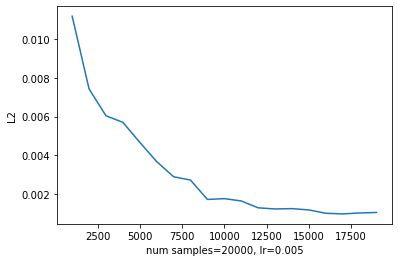

[0.011197409335523843, 0.007427526078652591, 0.006037679680390284, 0.00569678352214396, 0.004661163934273646, 0.0036598629518412055, 0.0028764121882850304, 0.0027040908484486864, 0.0017000221512280405, 0.0017433573200833052, 0.0016223096158937552, 0.0012670822463114746, 0.001207069247146137, 0.0012256386545486748, 0.0011567289380473085, 0.0009838031592662446, 0.0009505247335182503, 0.0009992400023620576, 0.0010264961494831368]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[-25 -20 -15 -10  -5   0   5  10  15  20  25]


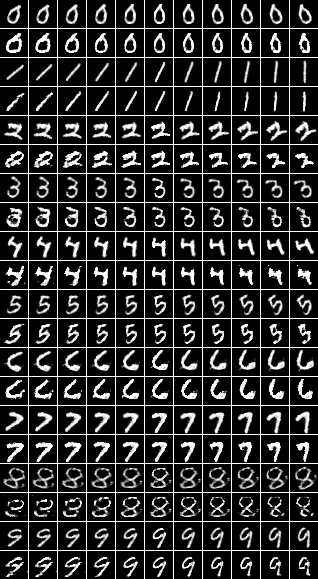

In [16]:
num_samples = 10

a = np.arange(-25,30,5)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -22.50, dist 0.01 +/- 0.00
alpha: -17.50, dist 0.01 +/- 0.01
alpha: -12.50, dist 0.01 +/- 0.01
alpha: -7.50, dist 0.01 +/- 0.01
alpha: -2.50, dist 0.01 +/- 0.00
alpha: 2.50, dist 0.01 +/- 0.00
alpha: 7.50, dist 0.01 +/- 0.00
alpha: 12.50, dist 0.01 +/- 0.00
alpha: 17.50, dist 0.01 +/- 0.00
alpha: 22.50, dist 0.01 +/- 0.00
2019-09-16 21:20:32,077 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-16 21:20:32,079 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


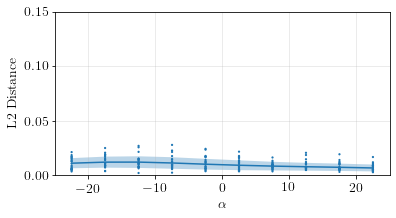

In [21]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'rot2d_NoAug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -25.00, dist 0.08 +/- 0.01
alpha: -20.00, dist 0.06 +/- 0.01
alpha: -15.00, dist 0.04 +/- 0.00
alpha: -10.00, dist 0.03 +/- 0.00
alpha: -5.00, dist 0.01 +/- 0.00
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 5.00, dist 0.01 +/- 0.00
alpha: 10.00, dist 0.02 +/- 0.00
alpha: 15.00, dist 0.04 +/- 0.00
alpha: 20.00, dist 0.06 +/- 0.01
alpha: 25.00, dist 0.07 +/- 0.01


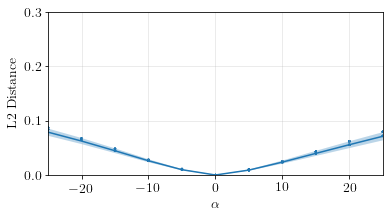

In [22]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'rot2d_NoAug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)